In [1]:
import fastai
from fastai.imports import *
import fastbook
from fastai.tabular.all import *

/opt/miniconda3/lib/python3.13/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")
/opt/miniconda3/lib/python3.13/site-packages/fastbook/__init__.py:17: UserWarning: Missing `graphviz` - please run `conda install fastbook` if needed
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook` if needed")


In [2]:
!ls

Code_no_age.ipynb     models                updated nta elisa.csv
Code.ipynb            nn_69.pkl


In [3]:
df = pd.read_csv("updated nta elisa.csv")

In [4]:
df.head()

,Patient No.,Age,Gender,ELISA,Patient/Control,NTA-Scatter
0,P37,50.0,F,145.84,Patient,8.400000e+10
1,P38,78.0,M,226.13,Patient,2.300000e+11
2,P39,38.0,M,NaN,Patient,6.900000e+10
3,P40,60.0,M,22.15,Patient,2.700000e+11
4,P41,41.0,M,59.31,Patient,1.000000e+11


In [5]:
del df['Age']

In [6]:
del df["Patient No."]

In [7]:
df.head()

,Gender,ELISA,Patient/Control,NTA-Scatter
0,F,145.84,Patient,8.400000e+10
1,M,226.13,Patient,2.300000e+11
2,M,NaN,Patient,6.900000e+10
3,M,22.15,Patient,2.700000e+11
4,M,59.31,Patient,1.000000e+11


In [8]:
df["Gender"].unique()

array(['F', 'M', 'f', 'm'], dtype=object)

In [9]:
gender_uc = df["Gender"].apply(lambda x: x.upper())
df["Gender"] = gender_uc

In [10]:
df.isna().sum()

Gender              0
ELISA              11
Patient/Control     0
NTA-Scatter         1
dtype: int64

In [11]:
df.shape

(70, 4)

In [12]:
df.columns

Index(['Gender', 'ELISA', 'Patient/Control', 'NTA-Scatter'], dtype='object')

In [13]:
df_no_age = df.fillna(method="bfill")

/var/folders/47/hv7ln5zn5hv_z3780m8c268c0000gn/T/ipykernel_24072/1097031848.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no_age = df.fillna(method="bfill")


In [14]:
df_no_age.isna().sum()

Gender             0
ELISA              0
Patient/Control    0
NTA-Scatter        0
dtype: int64

In [15]:
df_nn = df_no_age.dropna()

In [16]:
df_nn.isna().sum()

Gender             0
ELISA              0
Patient/Control    0
NTA-Scatter        0
dtype: int64

In [17]:
df_nn.head(3)

,Gender,ELISA,Patient/Control,NTA-Scatter
0,F,145.84,Patient,8.400000e+10
1,M,226.13,Patient,2.300000e+11
2,M,22.15,Patient,6.900000e+10


In [18]:
df_nn.dtypes

Gender              object
ELISA              float64
Patient/Control     object
NTA-Scatter        float64
dtype: object

In [19]:
splits = RandomSplitter(valid_pct = 0.2)(range_of(df_nn))
to = TabularPandas(df_nn, procs=[Categorify, FillMissing,Normalize],
                   y_block = CategoryBlock,
                   cat_names = ['Gender'],
                   cont_names = ['NTA-Scatter', 'ELISA'],
                   y_names='Patient/Control',
                   splits=splits)

In [20]:
to.xs.head()

,Gender,NTA-Scatter,ELISA
29,1,-0.676576,-0.562156
37,1,3.381234,-0.581501
63,2,0.073558,1.240065
17,2,-0.558445,-0.491549
33,2,0.605149,-0.413318


In [21]:
dls = to.dataloaders(bs=32,device="mps")

In [22]:
dls.show_batch()

,Gender,NTA-Scatter,ELISA,Patient/Control
0,M,2.300000e+11,1397.499966,Patient
1,F,4.200000e+10,532.649853,Patient
2,M,1.400000e+11,11534.090919,Control
3,M,3.300000e+11,10202.272283,Control
4,F,6.100000e+10,15011.363590,Patient
5,F,8.400000e+10,145.839917,Patient
6,F,9.200004e+09,17.399884,Control
7,M,3.900000e+11,10590.909346,Patient
8,F,8.400000e+10,145.839917,Patient
9,F,1.100000e+11,285.499966,Control


In [23]:
learn = tabular_learner(dls, metrics=accuracy)
learn.to(torch.device("mps"))

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=5, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [24]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,0.867115,0.664823,0.785714,00:00
1,0.823590,0.657401,0.785714,00:00
2,0.783977,0.649796,0.785714,00:00
3,0.767103,0.643553,0.785714,00:00
4,0.755423,0.636527,0.785714,00:00
5,0.741212,0.629967,0.785714,00:00
6,0.727727,0.622257,0.785714,00:00
7,0.711414,0.614152,0.785714,00:00
8,0.711617,0.608151,0.785714,00:00
9,0.693758,0.600470,0.785714,00:00


In [25]:
learn.export("nn_92-8_no_age.pkl")

In [26]:
indep_df = df_nn.drop(columns = ["Patient/Control"])

In [27]:
indep_df = pd.get_dummies(indep_df,columns=["Gender"],dtype="int")

In [28]:
dep_df = pd.get_dummies(df_nn["Patient/Control"],dtype='int',drop_first=True)

In [29]:
dep_df

,Patient
0,1
1,1
2,1
3,1
4,1
...,...
65,0
66,0
67,0
68,0


In [30]:
X = indep_df.values
Y = dep_df.values.ravel()

In [31]:
indep_df.corr()

,ELISA,NTA-Scatter,Gender_F,Gender_M
ELISA,1.000000,0.167107,-0.176351,0.176351
NTA-Scatter,0.167107,1.000000,-0.153429,0.153429
Gender_F,-0.176351,-0.153429,1.000000,-1.000000
Gender_M,0.176351,0.153429,-1.000000,1.000000


In [32]:
dep_df.value_counts()

Patient
1          50
0          20
Name: count, dtype: int64

In [35]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=42,test_size=0.2,shuffle=True,stratify=Y)

In [36]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.90      0.90      0.90        10

    accuracy                           0.86        14
   macro avg       0.82      0.82      0.82        14
weighted avg       0.86      0.86      0.86        14



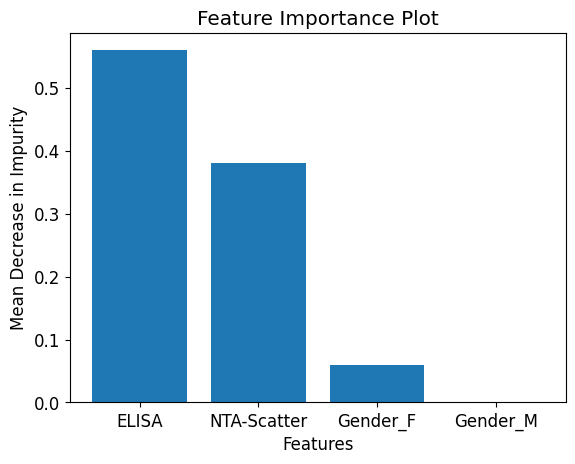

In [39]:
plt.bar(indep_df.columns , clf.feature_importances_)
plt.title("Feature Importance Plot")
plt.xlabel("Features")
plt.ylabel("Mean Decrease in Impurity")
plt.show()

In [40]:
plt.close()

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=1, random_state=0 ,)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       1.00      0.77      0.87        13

    accuracy                           0.79        14
   macro avg       0.62      0.88      0.63        14
weighted avg       0.95      0.79      0.84        14



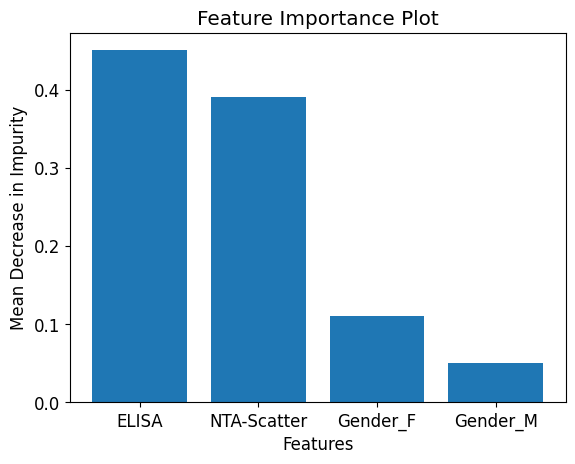

In [42]:
plt.bar(indep_df.columns , rf.feature_importances_)
plt.title("Feature Importance Plot")
plt.xlabel("Features")
plt.ylabel("Mean Decrease in Impurity")
plt.show()

In [43]:
plt.close()

In [44]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier().fit(X_train, y_train)
print("Train Accuracy:" ,hgb.score(X_train,y_train))
print("Test Accuracy :" ,hgb.score(X_test, y_test))

Train Accuracy: 0.75
Test Accuracy : 0.7857142857142857


In [47]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(metric='accuracy')

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training and validation sets
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Number of positive: 40, number of negative: 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714286 -> initscore=0.916291
[LightGBM] [Info] Start training from score 0.916291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [48]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       1.00      0.77      0.87        13

    accuracy                           0.79        14
   macro avg       0.62      0.88      0.63        14
weighted avg       0.95      0.79      0.84        14



In [149]:
learn_1 = tabular_learner(dls,metrics=error_rate,wd=1,layers=[50,100,50])
learn_1.to(torch.device("mps"))

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=5, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=50, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)

In [150]:
learn_1.fit_one_cycle(50)

epoch,train_loss,valid_loss,error_rate,time
0,0.707154,0.711198,0.785714,00:00
1,0.712863,0.715895,0.785714,00:00
2,0.719903,0.719936,0.785714,00:00
3,0.721018,0.723267,0.785714,00:00
4,0.704405,0.726768,0.785714,00:00
5,0.700114,0.731443,0.785714,00:00
6,0.702816,0.734483,0.785714,00:00
7,0.697241,0.736776,0.785714,00:00
8,0.700031,0.738517,0.785714,00:00
9,0.693858,0.741828,0.785714,00:00


In [151]:
learn_1.export("nn_87_no_age.pkl")

In [122]:
learn_1.export("nn_92-8(1)no_age.pkl")

In [155]:
learn_1 = tabular_learner(dls,metrics=error_rate,wd=1,layers=[50,100,50])
learn.opt_func = partial(Adam, wd=1)
learn_1.to(torch.device("mps"))

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=5, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=50, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)

In [156]:
learn_1.fit_one_cycle(50)

epoch,train_loss,valid_loss,error_rate,time
0,0.705653,0.673663,0.285714,00:00
1,0.715176,0.666451,0.285714,00:00
2,0.775860,0.656886,0.214286,00:00
3,0.734968,0.651889,0.214286,00:00
4,0.724693,0.646647,0.214286,00:00
5,0.701435,0.640740,0.214286,00:00
6,0.687722,0.638232,0.214286,00:00
7,0.676886,0.632803,0.214286,00:00
8,0.663396,0.626488,0.214286,00:00
9,0.663773,0.618145,0.214286,00:00


In [120]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2',).fit(X_train, y_train)
reg.score(X_train, y_train)

0.7142857142857143

In [95]:
y_pred_reg = reg.predict_proba(X_test)

In [93]:
classification_report(y_pred_reg,y_test)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       1.00      0.71      0.83        14\n\n    accuracy                           0.71        14\n   macro avg       0.50      0.36      0.42        14\nweighted avg       1.00      0.71      0.83        14\n'

In [94]:
y_test

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])

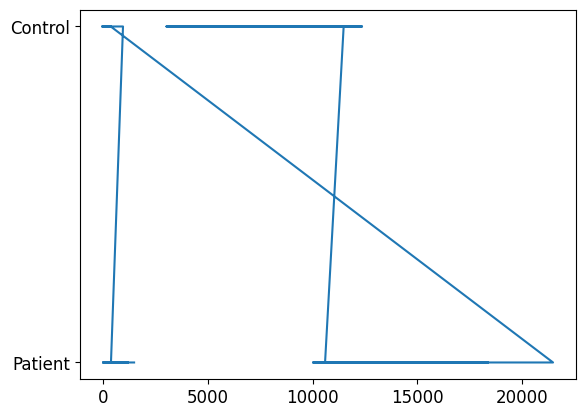

In [154]:
plt.plot(df['ELISA'],df['Patient/Control'],)

In [21]:
import fastai
from fastai.tabular.all import *
import gradio as gr
import pandas as pd
import numpy as np

# Load your trained model
model = load_learner('nn_92-8_no_age.pkl')

# Prediction function
def classify(gender, NTA_Scatter, ELISA):
    # Prepare input as a DataFrame
    df = pd.DataFrame([[gender, float(NTA_Scatter), float(ELISA)]],
                      columns=['Gender', 'NTA-Scatter', 'ELISA'])
    
    # Run prediction
    pred_class, pred_idx, probs = model.predict(df.iloc[0])
    
    # Get class names
    class_names = model.dls.vocab

    # Format the result as text
    result = "\n".join([f"{cls}: {probs[i]:.4f}" for i, cls in enumerate(class_names)])
    return f"Class probabilities:\n{result}"

# Gradio interface
demo = gr.Interface(fn=classify,
                    inputs=['text', 'number', 'number'],
                    outputs='textbox')

demo.launch(share=True)

/opt/miniconda3/lib/python3.13/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


* Running on local URL:  http://127.0.0.1:7881
* Running on public URL: https://95b10d06a31fc34180.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
import fastai
from fastai.tabular.all import *
import gradio as gr
import pandas as pd
import numpy as np

# Load your trained model
model = load_learner('nn_92-8_no_age.pkl')

# Prediction function
def classify(gender, NTA_Scatter, ELISA):
    df = pd.DataFrame([[gender, float(NTA_Scatter), float(ELISA)]],
                      columns=['Gender', 'NTA-Scatter', 'ELISA'])
    
    pred_class, pred_idx, probs = model.predict(df.iloc[0])
    class_names = model.dls.vocab

    # Format results for table display
    prob_df = pd.DataFrame({
        "Class": class_names,
        "Confidence": [f"{p:.4f}" for p in probs]
    })

    return str(pred_class), prob_df

# Interface
demo = gr.Interface(
    fn=classify,
    inputs=[
        gr.Dropdown(["F", "M"], label="Gender"),
        gr.Number(label="NTA-Scatter"),
        gr.Number(label="ELISA"),
    ],
    outputs=[
        gr.Label(label="Predicted Class"),
        gr.Dataframe(label="Class Probabilities", type="pandas")
    ],
    title="Patient vs Control Classifier",
    description="Enter patient data to classify whether they are likely a Patient or Control based on NTA-Scatter and ELISA values.",
    theme="default"
)

demo.launch(share=True)

/opt/miniconda3/lib/python3.13/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


* Running on local URL:  http://127.0.0.1:7889
* Running on public URL: https://628caa81c566a5163e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
